In [21]:

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

c:\Users\sim2real\AppData\Local\miniconda3\envs\dranet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:

print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('./data/facades/train/'))[2]))
print("평가 데이터셋 A와 B의 개수:", len(next(os.walk('./data/facades/val/'))[2]))
print("테스트 데이터셋 A와 B의 개수:", len(next(os.walk('./data/facades/test/'))[2]))

학습 데이터셋 A와 B의 개수: 400
평가 데이터셋 A와 B의 개수: 100
테스트 데이터셋 A와 B의 개수: 106


이미지 크기: (512, 256)


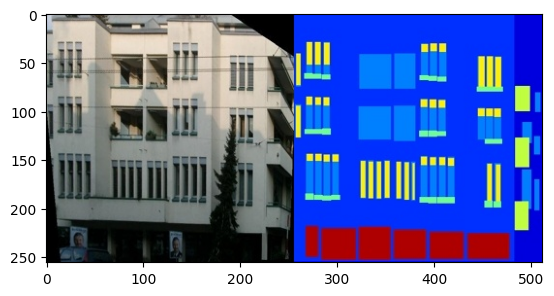

In [36]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./data/facades/train/1.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [37]:
class ImageDataset(Dataset):
    def __init__(self,root,transforms_=None,mode="train"):
        self.transform = transforms_
        self.files = sorted(glob.glob(os.path.join(root,mode)+"/*.jpg"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root,"test")+"/*.jpg")))
        
    def __getitem__(self, index):
        img = Image.open(self.files[index%len(self.files)])
        w,h = img.size
        img_A = img.crop((0,0,w/2,h)) # 이미지의 왼쪽 절반 
        img_B = img.crop((w/2,0,w,h)) # 이미지의 오른쪽 절반 

        # 데이터 증강(Data Agumentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:,::-1,:],"RGB")
            img_B = Image.fromarray(np.array(img_B)[:,::-1,:],"RGB")
        
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A":img_A,"B":img_B}
    
    def __len__(self):
        return len(self.files)



In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize((256,256),Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,.5,.5))
])

train_dataset = ImageDataset("./data/facades",transforms_=transforms_)
val_dataset = ImageDataset("./data/facades",transforms_=transforms_)

train_dataloader = DataLoader(train_dataset,batch_size=10,shuffle=True,num_workers=0)
val_dataloader = DataLoader(val_dataset,batch_size=10,shuffle=True,num_workers=0)